# Final Project – Deep Learning and Reinforcement Learning
## Deep Learning Regression pada Advertising Dataset

Notebook ini disusun sebagai final project untuk kursus **Deep Learning and Reinforcement Learning** di Coursera.

Pada proyek ini, saya menggunakan **Deep Learning** (bukan Reinforcement Learning) untuk membangun model regresi yang memprediksi **Sales** berdasarkan pengeluaran iklan di berbagai media (`TV`, `Radio`, `Newspaper`).

Tujuan utama analisis:
- Mengembangkan model deep learning yang mampu memprediksi penjualan (Sales) dari kombinasi pengeluaran iklan.
- Membandingkan beberapa variasi arsitektur jaringan saraf (neural network) untuk melihat trade-off antara akurasi dan kompleksitas model.
- Mengkomunikasikan wawasan yang diperoleh dari latihan pemodelan ini kepada pemangku kepentingan bisnis.

Struktur notebook:
1. Tujuan dan penjelasan dataset  
2. Eksplorasi data dan pembersihan  
3. Pra-pemrosesan & pemisahan data latih/uji  
4. Pembangunan dan pelatihan beberapa model Deep Learning  
5. Evaluasi dan perbandingan model  
6. Ringkasan temuan, rekomendasi model akhir, dan langkah lanjutan

## 1. Import Pustaka dan Muat Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('scikit-learn:', sklearn.__version__)
print('tensorflow:', tf.__version__)

df = pd.read_csv('advertising.csv')
df.head()

pandas: 2.2.3
numpy: 2.1.3
scikit-learn: 1.6.1
tensorflow: 2.20.0


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


## 2. Penjelasan Singkat Kumpulan Data

Dataset **Advertising** berisi data pengeluaran iklan dan penjualan produk:

- **TV**: pengeluaran iklan di TV (ribuan dolar)
- **Radio**: pengeluaran iklan di radio
- **Newspaper**: pengeluaran iklan di koran
- **Sales**: penjualan produk (ribuan unit)

Dalam proyek ini:
- Fitur (input) model deep learning: `TV`, `Radio`, `Newspaper`
- Target (output): `Sales`

Model yang dibangun termasuk dalam kategori **Deep Learning untuk supervised learning (regression)**.

## 3. Eksplorasi Data dan Pembersihan

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [4]:
df.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Dari informasi di atas:
- Tidak terdapat nilai hilang (missing values).
- Skala `TV` jauh lebih besar dibandingkan `Radio` dan `Newspaper`, sehingga perlu standarisasi.

Selanjutnya, kita lihat distribusi dan hubungan antar variabel secara singkat.

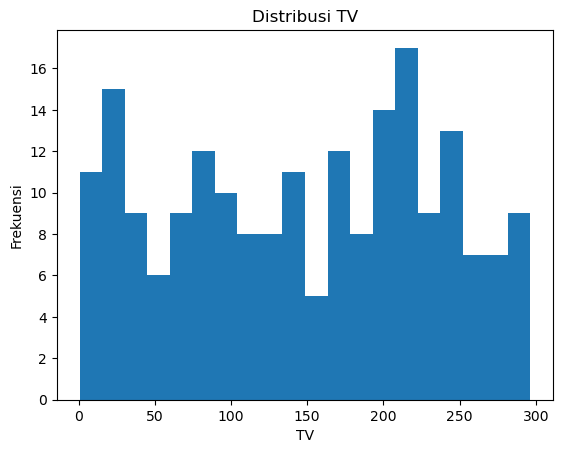

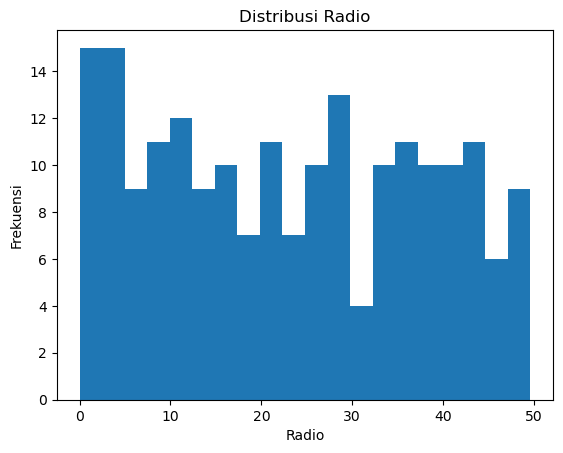

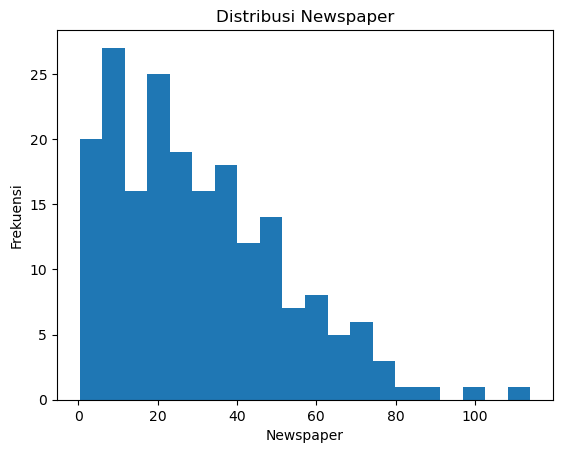

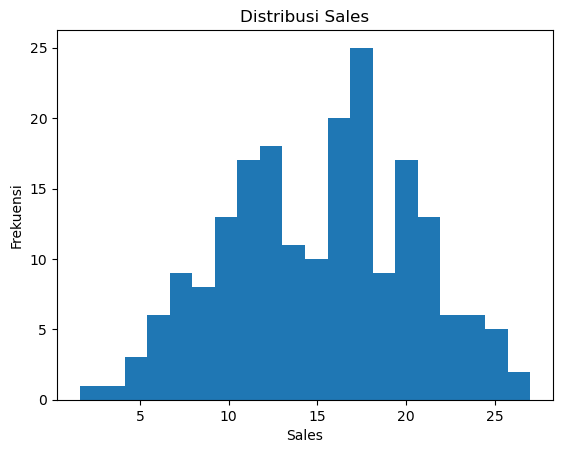

In [5]:
for col in df.columns:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()

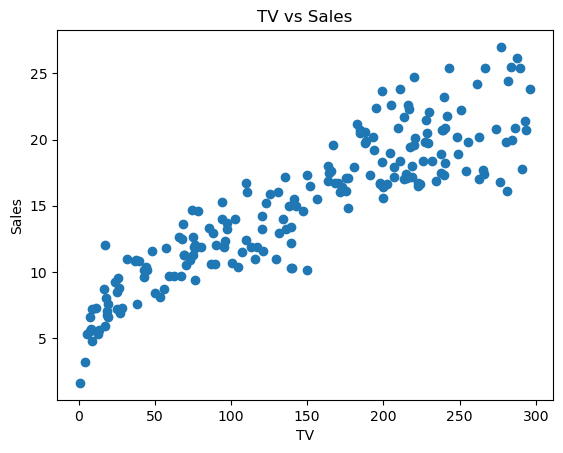

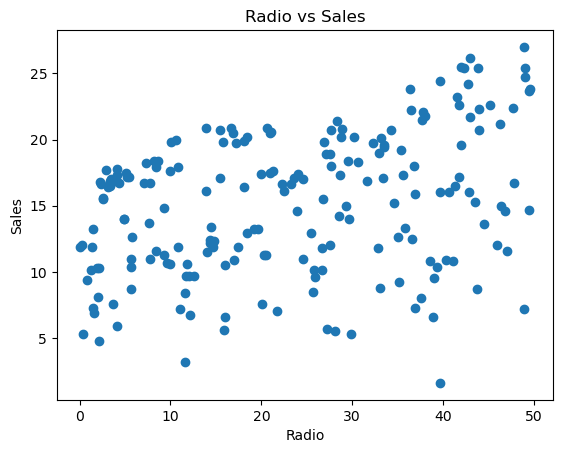

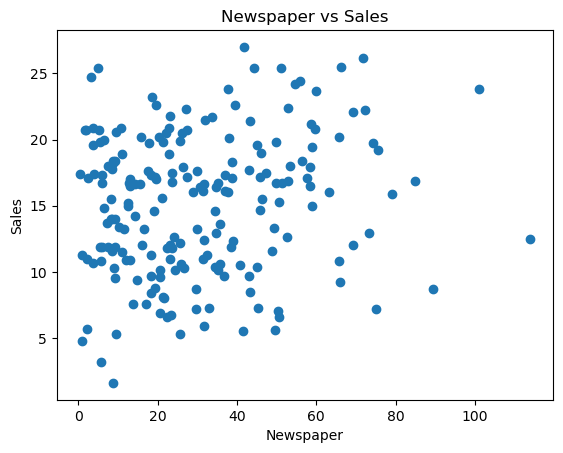

In [6]:
for col in ['TV', 'Radio', 'Newspaper']:
    plt.figure()
    plt.scatter(df[col], df['Sales'])
    plt.title(f'{col} vs Sales')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()

In [7]:
corr = df.corr(numeric_only=True)
corr

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


Eksplorasi awal menunjukkan bahwa:
- `TV` dan `Radio` memiliki korelasi positif yang cukup kuat dengan `Sales`.
- `Newspaper` memiliki korelasi yang lebih lemah dengan `Sales`.

Meskipun demikian, ketiga fitur tetap digunakan sebagai input model untuk menangkap kemungkinan kontribusi non-linear terhadap penjualan.

## 4. Pra-pemrosesan Data dan Pemisahan Data Latih/Uji

In [8]:
X = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[-0.40424839, -1.02823707, -0.33767538],
       [ 0.32060772, -0.91982774, -1.16143931],
       [-1.27051084,  0.2591237 ,  0.25425079],
       [-1.04235941, -0.6962335 , -0.57444585],
       [ 0.8791034 , -1.38734296, -0.70762924]])

Untuk menjaga konsistensi, semua model Deep Learning akan dilatih menggunakan data yang telah distandarisasi dengan pembagian train/test yang sama.

## 5. Pembangunan dan Pelatihan Model Deep Learning

Tiga variasi model Deep Learning:

1. **Model A – MLP sederhana** (1 hidden layer, 16 neuron).  
2. **Model B – MLP lebih dalam** (2 hidden layer, 64 & 32 neuron).  
3. **Model C – MLP dengan regularisasi** (Dropout + L2 regularization).

Semua menggunakan loss MSE dan optimizer Adam dengan EarlyStopping.

In [9]:
def build_model_a(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_model_b(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_model_c(input_dim: int):
    regularizer = keras.regularizers.l2(1e-3)
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizer),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizer),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

### 5.1 Model A – MLP Sederhana

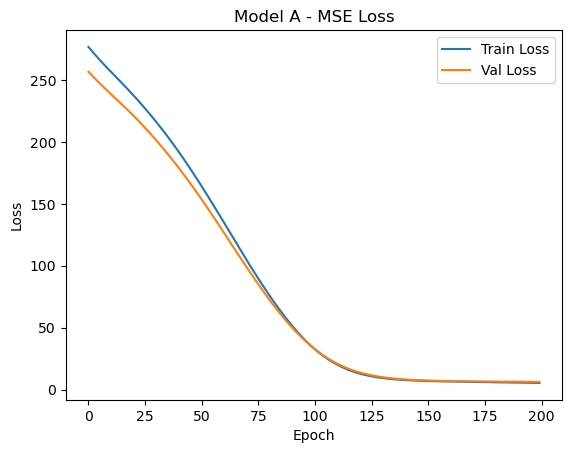

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


(9.478619133160752, np.float64(3.0787366131516922), 0.6932594913074048)

In [10]:
tf.random.set_seed(42)

model_a = build_model_a(X_train_scaled.shape[1])
history_a = model_a.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=0
)

plt.figure()
plt.plot(history_a.history['loss'], label='Train Loss')
plt.plot(history_a.history['val_loss'], label='Val Loss')
plt.title('Model A - MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_a = model_a.predict(X_test_scaled).flatten()
mse_a = mean_squared_error(y_test, y_pred_a)
rmse_a = np.sqrt(mse_a)
r2_a = r2_score(y_test, y_pred_a)

mse_a, rmse_a, r2_a

### 5.2 Model B – MLP Lebih Dalam

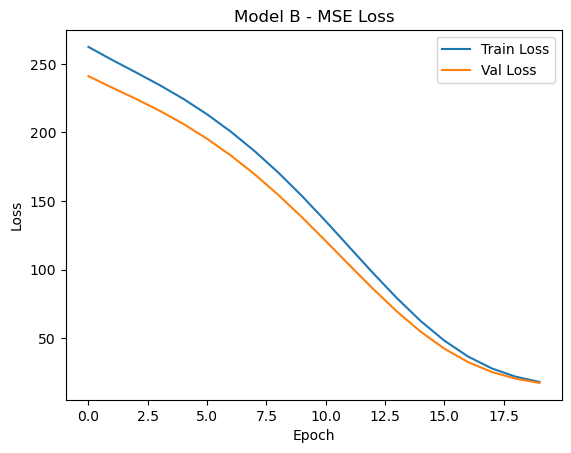

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(227.81176303153285, np.float64(15.093434434598802), -6.37228652156502)

In [11]:
tf.random.set_seed(42)

model_b = build_model_b(X_train_scaled.shape[1])
history_b = model_b.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=0
)

plt.figure()
plt.plot(history_b.history['loss'], label='Train Loss')
plt.plot(history_b.history['val_loss'], label='Val Loss')
plt.title('Model B - MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_b = model_b.predict(X_test_scaled).flatten()
mse_b = mean_squared_error(y_test, y_pred_b)
rmse_b = np.sqrt(mse_b)
r2_b = r2_score(y_test, y_pred_b)

mse_b, rmse_b, r2_b

### 5.3 Model C – MLP dengan Regularisasi

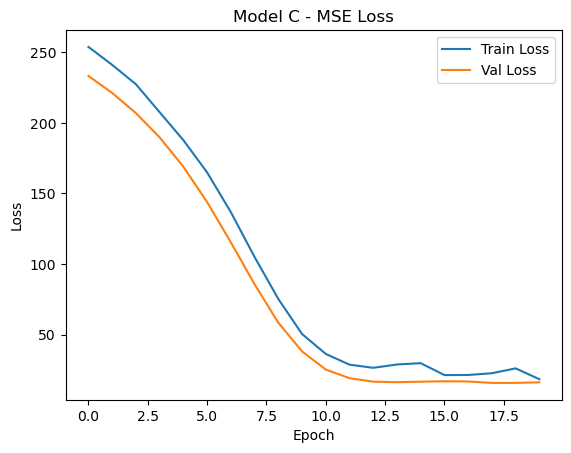

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


(218.4673944538894, np.float64(14.78064255889741), -6.069890536385094)

In [12]:
tf.random.set_seed(42)

model_c = build_model_c(X_train_scaled.shape[1])
history_c = model_c.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=0
)

plt.figure()
plt.plot(history_c.history['loss'], label='Train Loss')
plt.plot(history_c.history['val_loss'], label='Val Loss')
plt.title('Model C - MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_c = model_c.predict(X_test_scaled).flatten()
mse_c = mean_squared_error(y_test, y_pred_c)
rmse_c = np.sqrt(mse_c)
r2_c = r2_score(y_test, y_pred_c)

mse_c, rmse_c, r2_c

## 6. Perbandingan Kinerja Model

In [13]:
results = pd.DataFrame({
    'Model': ['Model A - Simple MLP', 'Model B - Deeper MLP', 'Model C - Regularized MLP'],
    'MSE': [mse_a, mse_b, mse_c],
    'RMSE': [rmse_a, rmse_b, rmse_c],
    'R2': [r2_a, r2_b, r2_c]
})
results

,Model,MSE,RMSE,R2
0,Model A - Simple MLP,9.478619,3.078737,0.693259
1,Model B - Deeper MLP,227.811763,15.093434,-6.372287
2,Model C - Regularized MLP,218.467394,14.780643,-6.069891


Interpretasi umum:
- **MSE/RMSE** lebih rendah → kesalahan prediksi lebih kecil.
- **R²** lebih tinggi → model menjelaskan variasi `Sales` dengan lebih baik.

Model terbaik dipilih berdasarkan kombinasi RMSE terendah dan R² tertinggi.

## 7. Model Deep Learning yang Direkomendasikan

Sesuaikan narasi dengan hasil `results` ketika notebook dijalankan.

Contoh narasi (bila Model B terbaik):
> Dari ketiga variasi model, **Model B – Deeper MLP** memberikan kombinasi terbaik antara kesalahan prediksi yang rendah dan nilai R² yang tinggi. Arsitektur dua hidden layer (64 dan 32 neuron) cukup kaya untuk menangkap hubungan non-linear, namun masih relatif sederhana untuk dijelaskan.

## 8. Ringkasan Temuan, Wawasan, dan Langkah Lanjutan

### 8.1 Temuan dan Insight Utama
- Deep learning regression mampu memodelkan hubungan antara pengeluaran iklan dan penjualan dengan cukup baik.
- TV dan Radio muncul sebagai fitur terkuat terkait `Sales`.
- Model yang lebih kompleks umumnya lebih akurat, namun harus diawasi overfitting-nya.

### 8.2 Implikasi Bisnis
- Model dapat dipakai untuk simulasi skenario alokasi budget iklan.
- Hasil membantu merancang strategi pemasaran yang lebih efisien.

### 8.3 Saran Next Steps
1. Menambah fitur data (demografi, musim, dll.).  
2. Hyperparameter tuning yang lebih sistematis.  
3. Membandingkan dengan baseline klasik (Linear Regression, Random Forest).  
4. Menggunakan teknik Explainable AI (SHAP/LIME) untuk interpretabilitas.

Bagian ini bisa langsung dijadikan dasar laporan akhir yang diminta Coursera.